In [84]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [42]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [43]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [44]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [45]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


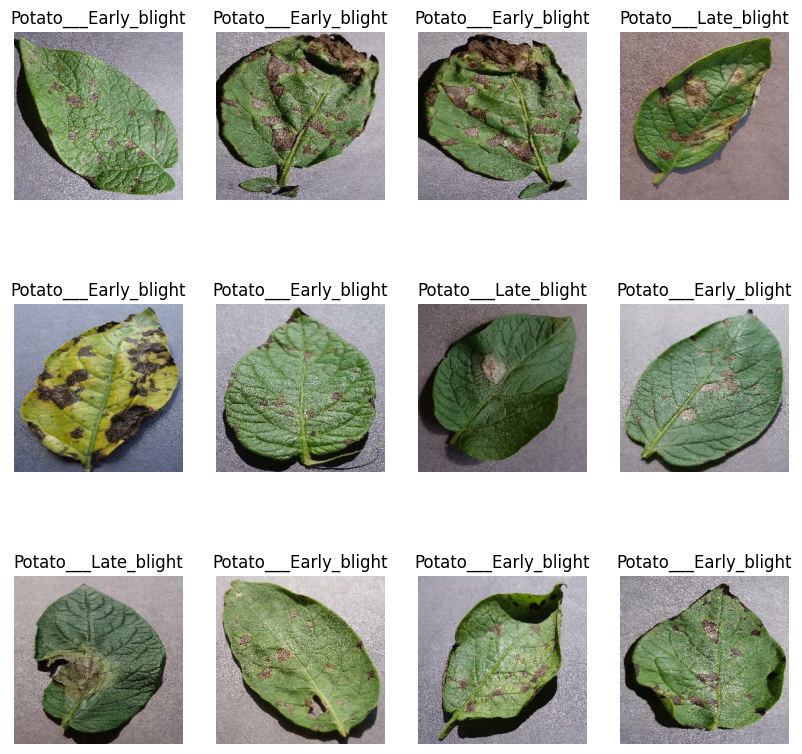

In [46]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [47]:
len(dataset)

68

In [48]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [49]:
train_ds = dataset.take(54)
len(train_ds)

54

In [50]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [51]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [52]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [53]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [54]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [55]:
len(train_ds)

54

In [56]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [57]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [58]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [59]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [78]:
import tensorflow as tf
from tensorflow.keras import layers, models

def yolov8_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # YOLOv8 Architecture
    # ... Your YOLOv8 architecture implementation here ...

    # Example: Three convolutional layers with max pooling
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # ...

    x = layers.Flatten()(x)

    # Dense Block
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Assuming you have defined BATCH_SIZE, IMAGE_SIZE, CHANNELS
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

yolov8_model = yolov8_model(input_shape, n_classes)
yolov8_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_52 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 64, 64, 256)       2951

In [82]:
yolov8_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [83]:
history = yolov8_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 255s 5s/step - loss: 185.0985 - accuracy: 0.5914 - val_loss: 0.5092 - val_accuracy: 0.8281
Epoch 2/50
54/54 [==============================] - 247s 5s/step - loss: 0.6940 - accuracy: 0.7587 - val_loss: 0.6620 - val_accuracy: 0.7292
Epoch 3/50
54/54 [==============================] - 264s 5s/step - loss: 0.6988 - accuracy: 0.7512 - val_loss: 0.6288 - val_accuracy: 0.7448
Epoch 4/50
54/54 [==============================] - 255s 5s/step - loss: 0.6081 - accuracy: 0.7899 - val_loss: 0.5884 - val_accuracy: 0.7604
Epoch 5/50
54/54 [==============================] - 249s 5s/step - loss: 0.6183 - accuracy: 0.7928 - val_loss: 0.4677 - val_accuracy: 0.8490
Epoch 6/50
54/54 [==============================] - 239s 4s/step - loss: 0.5321 - accuracy: 0.8264 - val_loss: 0.5883 - val_accuracy: 0.7708
Epoch 7/50
54/54 [==============================] - 242s 4s/step - loss: 0.5065 - accuracy: 0.8160 - val_loss: 0.4740 - val_accuracy: 0.8021
Epoch 8/50


In [88]:
scores = yolov8_model.evaluate(test_ds)

8/8 [==============================] - 4s 462ms/step - loss: 0.4448 - accuracy: 0.8203


In [89]:
scores

[0.4447629749774933, 0.8203125]

In [90]:
history

In [91]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [92]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [93]:
type(history.history['loss'])

list

In [94]:
len(history.history['loss'])

50

In [95]:
len(history.history['loss'])

50

In [96]:
history.history['loss'][:5] # show loss for first 5 epochs

[185.0985107421875,
 0.6939762234687805,
 0.6988043189048767,
 0.6081361174583435,
 0.6183313727378845]

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

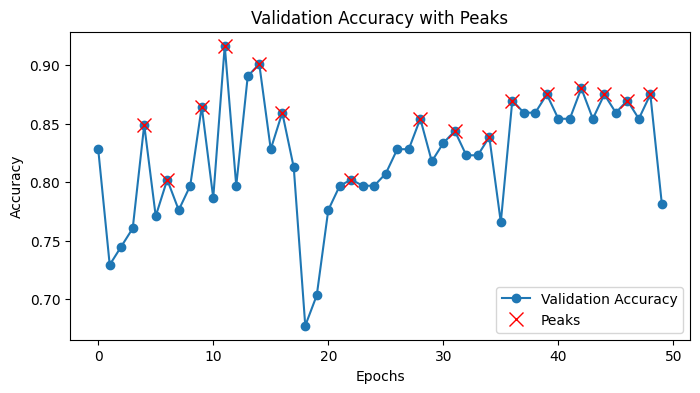

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming you have the list val_acc from your training history

# Convert the list to a numpy array for compatibility with find_peaks
val_acc_np = np.array(val_acc)

# Find peaks in the validation accuracy
peaks, _ = find_peaks(val_acc_np)

plt.figure(figsize=(8, 4))

# Plotting the validation accuracy
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy', marker='o')

# Plotting the peaks
plt.plot(peaks, val_acc_np[peaks], 'rx', label='Peaks', markersize=10)

plt.legend(loc='lower right')
plt.title('Validation Accuracy with Peaks')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()


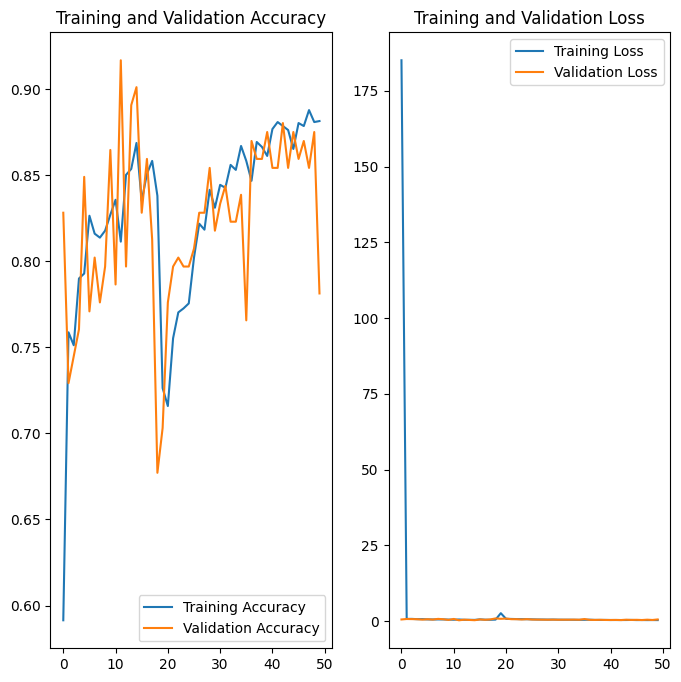

In [99]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [101]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\ES Lab\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Early_blight


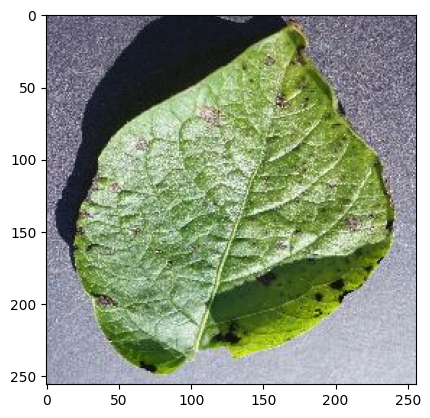

In [103]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = yolov8_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [104]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 51ms/step


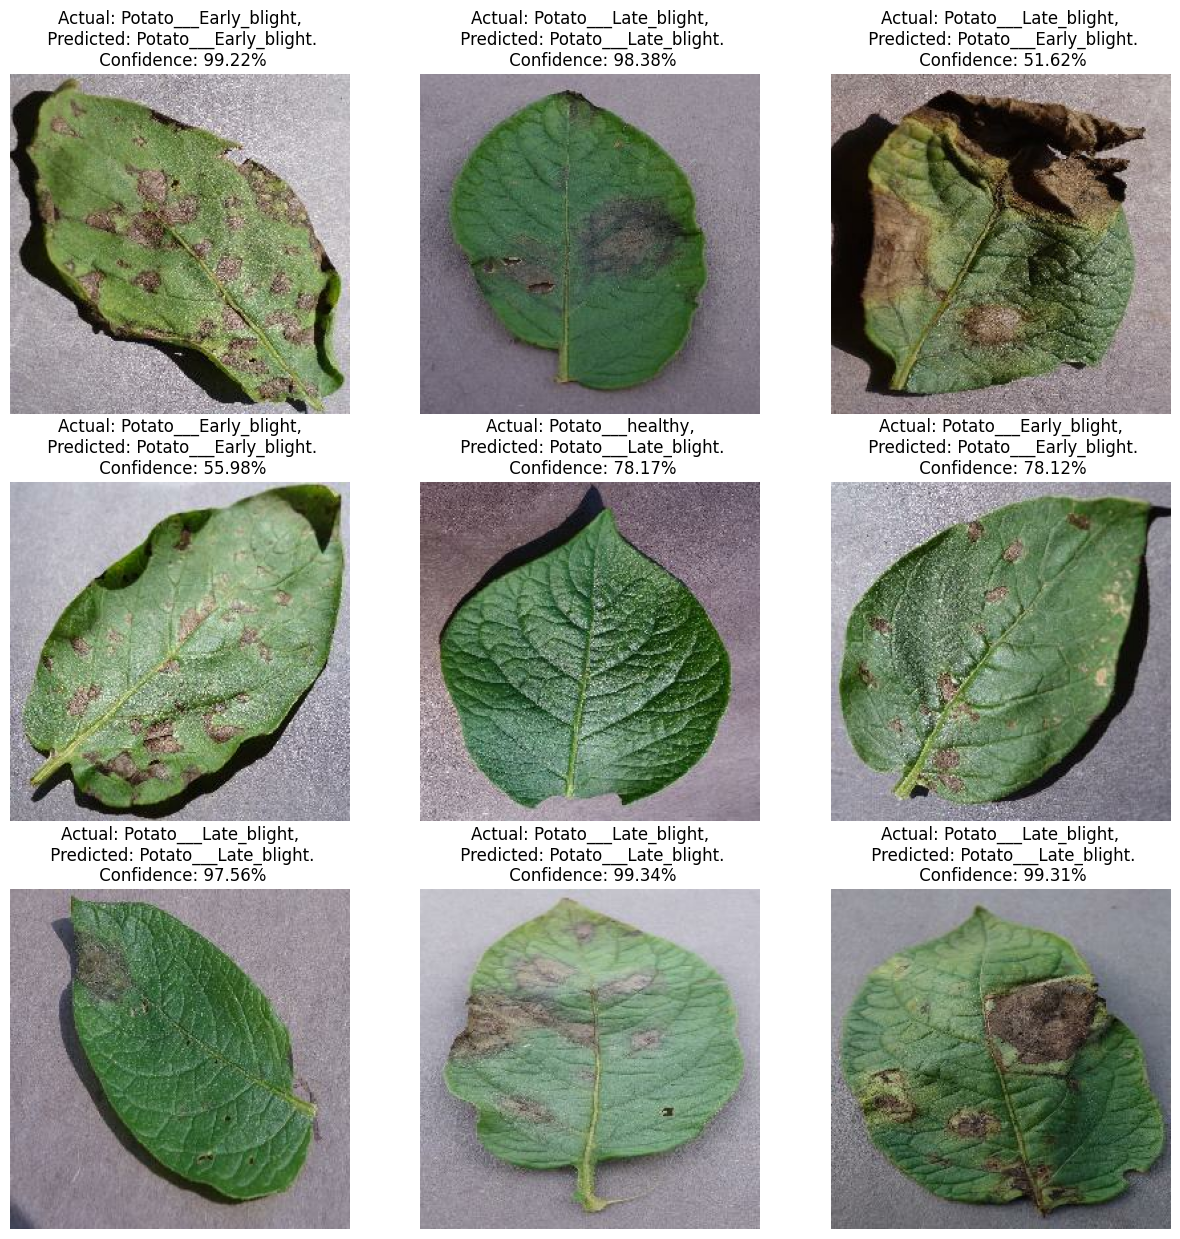

In [106]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(yolov8_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [107]:
import os
model_version=max([int(i) for i in os.listdir("../yolov8_adam") + [0]])+1
yolov8_model.save(f"../yolov8_adam/{model_version}")

INFO:tensorflow:Assets written to: ../yolov8_adam/1\assets


INFO:tensorflow:Assets written to: ../yolov8_adam/1\assets


In [108]:
model.save("../yolov8adam.h5")

C:\Users\ES Lab\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
